<a href="https://www.kaggle.com/code/abdusalam7474/sentiment-analyis-ml-dl-dbert?scriptVersionId=173353036" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### 🔵 Installing and importing libraries <a class="anchor"  id="a1"></a>

In [1]:
## Install necessary libraries

! pip install -Uqqq seaborn
! pip install -Uqqq squarify
! pip install -Uqqq nltk
! pip install -Uqqq wordcloud
! pip install -Uqqq spacy
! pip install -Uqqq imblearn
! pip install -Uqqq gensim
!python -m spacy download en_core_web_sm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
ydata-profiling 4.5.1 requires seaborn<0.13,>=0.10.1, but you have seaborn 0.13.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
ydata-profiling 4.5.1 requires seaborn<0.13,>=0.10.1, but you have seaborn 0.1

In [2]:
## Importing the necessary libraries 

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import requests
from PIL import Image
from collections import Counter
import squarify
from tqdm import tqdm

import string
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud ,STOPWORDS
import spacy
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import tensorflow as tf
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.13.0
REPLICAS:  1


In [4]:
## Helper functions

def add_spines(colour = '#425169', linewidth = 2):
    """
    Add beautiful spines to you plots
    """
    ax = plt.gca()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines[['bottom', 'left', 'top', 'right']].set_color(colour)
    ax.spines[['bottom', 'left', 'top', 'right']].set_linewidth(linewidth)

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

### 🔵 Basic preprocessing and sample tweets <a class="anchor"  id="a2"></a>

In [5]:
df = pd.read_csv("/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv")
df = df.drop(['id', 'index'], axis=1)
df.rename(columns={'oh_label': 'Label'}, inplace=True)
df = df.dropna(subset=['Label'])

# analysis of mentions and tweets

# here we create a function to count the number of hashtags and mentions and then create two columns to store this data
def count_symbols(text):
    hashtag_count = len(re.findall(r'#', text))
    mention_count = len(re.findall(r'@', text))
    return hashtag_count, mention_count

# Apply the function to each row in the 'text' column
df[['num_hashtags', 'num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))

print('\nDataset shape: ', df.shape)
df.head()


Dataset shape:  (16848, 5)


,Text,Annotation,Label,num_hashtags,num_mentions
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,0,3
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,0,1
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,0,1
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,0,1
4,#mkr No No No No No No,none,0.0,1,0


In [6]:
print('_________Sample tweets_________')
simple_tweet = df[df['Label'] == 0]['Text'].iloc[1]
print('\nSimple tweet: ', simple_tweet)
sexist_tweet = df[df['Annotation'] == 'sexism']['Text'].iloc[0]
print('\n\nSexist tweet: ', sexist_tweet)
racist_tweet = df[df['Annotation'] == 'racism']['Text'].iloc[0]
print('\n\nRacist tweet: ', racist_tweet)
print('\n_______________________________')

_________Sample tweets_________

Simple tweet:  @ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.


Sexist tweet:  RT @Mooseoftorment Call me sexist, but when I go to an auto place, I'd rather talk to a guy


Racist tweet:  @g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.

_______________________________


# 🕵🏻 Exploratory Data Analysis <a class="anchor"  id="chapter1"></a>

>We analyse different aspects of the twitter dataset here. We start with simple tasks like understanding the label and Annotation distribution, and slowly progress toward extracting and analysing #hastags, @mentions and finally generate wordclouds of high frequency words according to annotations. 

In [7]:
## Basic analysis of labels and annotations

print('Label distribution')
print(df.Label.value_counts())
print('-------------------------\n')
print('Annotation distribution')
print(df.Annotation.value_counts())
print('-------------------------\n')
print('Grouping of Annotation with label')
print(df.groupby('Annotation')['Label'].sum())

Label distribution
Label
0.0    11501
1.0     5347
Name: count, dtype: int64
-------------------------

Annotation distribution
Annotation
none      11501
sexism     3377
racism     1970
Name: count, dtype: int64
-------------------------

Grouping of Annotation with label
Annotation
none         0.0
racism    1970.0
sexism    3377.0
Name: Label, dtype: float64


As seen, the text with annotations of anything other than none are all classified as toxic. Hence, it would be a dead giveaway to include it in our dataset. We may try to classify the text with the annotations later
___

In [8]:
def bully_palette(df,column, positions_to_change: list):
    """
    A function to create grey red palettes according to the inputs
    You just need to pass in the dataframe and the index of labels to be highlighted in red
    """
    palette = ['#96898b']*df[column].nunique()
    new_values = ['#cc253b']*len(positions_to_change)
    for position, new_value in zip(positions_to_change, new_values):
        palette[position] = new_value
    return sns.color_palette(palette)
    
# example
# bully_palette(df,'Label', [0, 1])

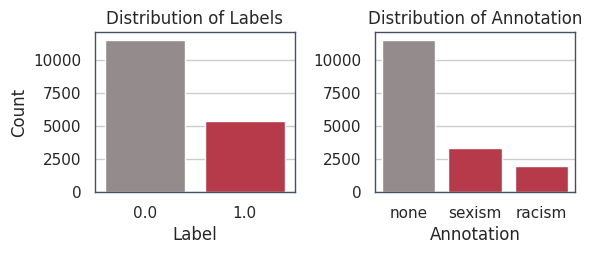

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 2))

plt.subplot(1, 2, 1)
# using the bully_pallete function to create a custom pallete
sns.countplot(x='Label', data=df, palette = bully_palette(df, 'Label', [1]))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
# adding spines using the helper function we declared earlier
add_spines(linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='Annotation', data=df, palette = bully_palette(df,'Annotation', [1, 2]))
plt.xlabel('Annotation')
plt.ylabel('')
plt.title('Distribution of Annotation')
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.3)
plt.show()

This is how our highlighted plots turned out.

We can see that the lable `1` has further been divided into the categories `sexism` and `racism`. Sexism is more prevelant than racism. Racism is looked upon more harshly by the public or twitter might be efficient at removing racist tweets from their site (we never know🤷‍♀️).

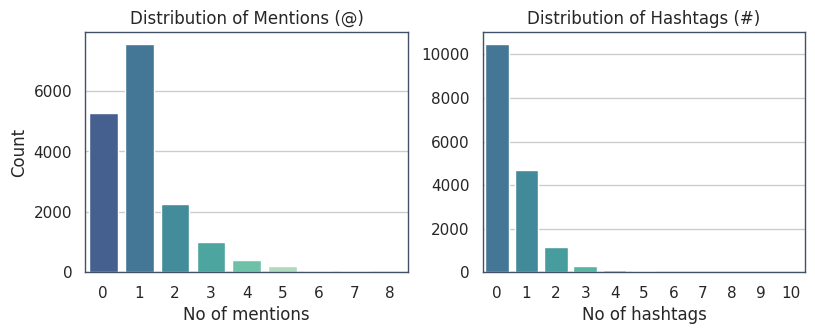

In [10]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.countplot(x='num_mentions', data=df, palette =  sns.color_palette("mako", n_colors=9)[3:])
plt.xlabel('No of mentions')
plt.ylabel('Count')
plt.title('Distribution of Mentions (@)')
add_spines(linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='num_hashtags', data=df, palette = sns.color_palette("mako", n_colors=11)[5:])
plt.xlabel('No of hashtags')
plt.ylabel('')
plt.title('Distribution of Hashtags (#)')
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.23, hspace=0.3)
plt.show()

<Figure size 600x300 with 0 Axes>

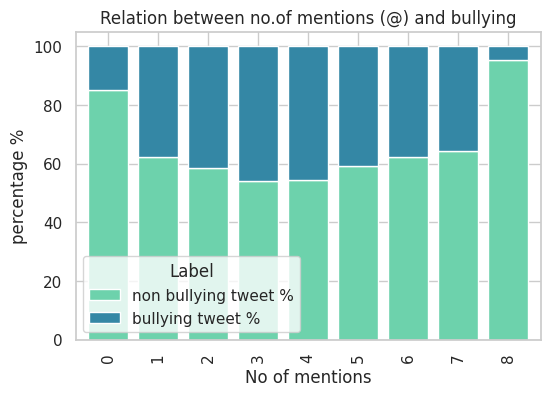

In [11]:
plt.figure(figsize=(6, 3))
mention_label_cross = pd.crosstab(df['num_mentions'], df['Label'])
mention_label_cross['sum'] = mention_label_cross[0.0] + mention_label_cross[1.0]
mention_label_cross['non bullying tweet %'] = mention_label_cross[0.0]/mention_label_cross['sum']*100
mention_label_cross['bullying tweet %'] = mention_label_cross[1.0]/mention_label_cross['sum']*100
mention_label_cross = mention_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

mention_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('No of mentions')
plt.ylabel('percentage %')
plt.title('Relation between no.of mentions (@) and bullying')
plt.show()

> Here you can see that as the mentions increase to 4, the percentage of bullying tweets increases compared to the normal ones. But the trend once again reverses as the mentions increase upto 8. No clear pattern was seen between number of hashtags and percentage of bullying tweets

### Sentiment analysis
Here we check whether the sentiment of the tweets directly correlate with bullying. ie. more  negativity a tweet contains, higher the probability of bullying.

In [12]:
## Using the nltk library to analyze sentiment of each text so that we can correlate it with bullying
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment of a text
def get_sentiment(text):
    compound_score = sia.polarity_scores(text)['compound']
    return 'positive' if compound_score >= 0 else 'negative'


df['Sentiment_Label'] = df['Text'].apply(get_sentiment)

df.head()

,Text,Annotation,Label,num_hashtags,num_mentions,Sentiment_Label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,0,3,negative
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,0,1,negative
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,0,1,positive
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,0,1,negative
4,#mkr No No No No No No,none,0.0,1,0,negative


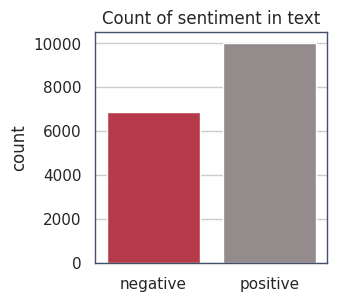

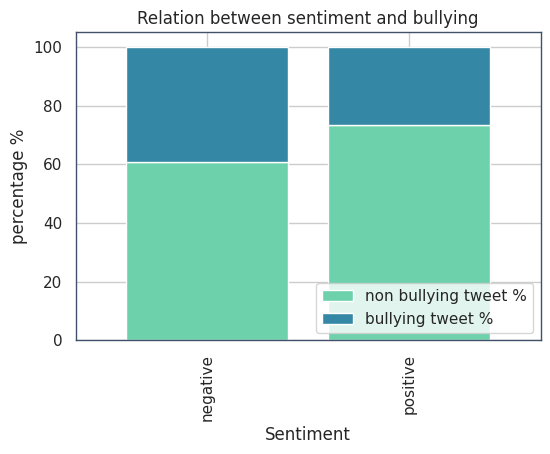

In [13]:
plt.figure(figsize=(3, 3))
df['Sentiment_Label'].value_counts()
sns.countplot(x='Sentiment_Label', data=df, palette = bully_palette(df, 'Sentiment_Label', [0]))
plt.title('Count of sentiment in text')
plt.xlabel('')
add_spines(linewidth=1)

sent_label_cross = pd.crosstab(df['Sentiment_Label'], df['Label'])
sent_label_cross['sum'] = sent_label_cross[0.0] + sent_label_cross[1.0]
sent_label_cross['non bullying tweet %'] = sent_label_cross[0.0]/sent_label_cross['sum']*100
sent_label_cross['bullying tweet %'] = sent_label_cross[1.0]/sent_label_cross['sum']*100
sent_label_cross = sent_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

ax = sent_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('Sentiment')
plt.ylabel('percentage %')
plt.title('Relation between sentiment and bullying')
ax.legend(loc='lower right')
add_spines(linewidth=1)

plt.show()

 The dataset contains a lot of negative tweets... which is a good thing since our models should be able to understand the difference between a `negative` tweet and a `bullying` tweet. It shouldn't flag every other negative tweet as bullying.

### Analysis of common hashtags and mentions


In [14]:
## Extraction of the top ten mentions and hashtags in the dataset

# Function to extract hashtags from a text
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

df['Hashtags'] = df['Text'].apply(extract_hashtags)

# Function to extract hashtags from a text
def extract_mentions(text):
    return re.findall(r'@\w+', text)

df['Mentions'] = df['Text'].apply(extract_mentions)

def create_counter_df(df):
    """
    Creates a dataframe that contains the Label and their count.
    Pass the dataframe containing the labels in the form of a list column as an input.
    Example usage:
    1. mentions = create_counter_df(df['Mentions'])
    2. sexist_mentions = create_counter_df(df[df.Annotation=='sexist']["Mentions"])
    """
    # Flatten the list of hashtags and count their occurrences
    all_counts = [tag for counts_list in df for tag in counts_list]
    label_counts = Counter(all_counts)

    # Create a DataFrame from the Counter dictionary
    counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
    counts_df = counts_df.sort_values(by='Count', ascending=False)
    return counts_df
    
mentions_df = create_counter_df(df['Mentions'])
top_10_mentions = mentions_df.head(10)
sexist_mentions = create_counter_df(df[df.Annotation=='sexism']["Mentions"])
top_10_sexist_mentions = sexist_mentions.head(10)
racist_mentions = create_counter_df(df[df.Annotation=='racism']["Mentions"])
top_10_racist_mentions = racist_mentions.head(10)

hashtags_df = create_counter_df(df['Hashtags'])
top_10_hashtags = hashtags_df.head(10)
sexist_hashtags = create_counter_df(df[df.Annotation=='sexism']["Hashtags"])
top_10_sexist_hashtags = sexist_hashtags.head(10)
racist_hashtags = create_counter_df(df[df.Annotation=='racism']["Hashtags"])
top_10_racist_hashtags = racist_hashtags.head(10)

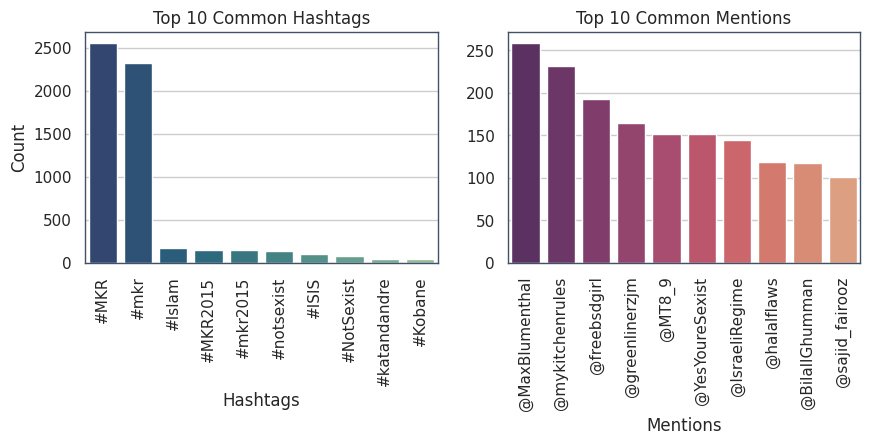

In [15]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
sns.barplot(x='Label', y='Count', data=top_10_hashtags, palette='crest_r')
plt.title('Top 10 Common Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(122)
sns.barplot(x='Label', y='Count', data=top_10_mentions, palette='flare_r')
plt.title('Top 10 Common Mentions')
plt.xlabel('Mentions')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

<img src="https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/twitter_%23%40.png"
     width="300000000" />
     
`#MKR` (@mykitchenrules) is the most popular hashtag in the dataset whereas `@MaxBlumenthal` is the most popular mention.


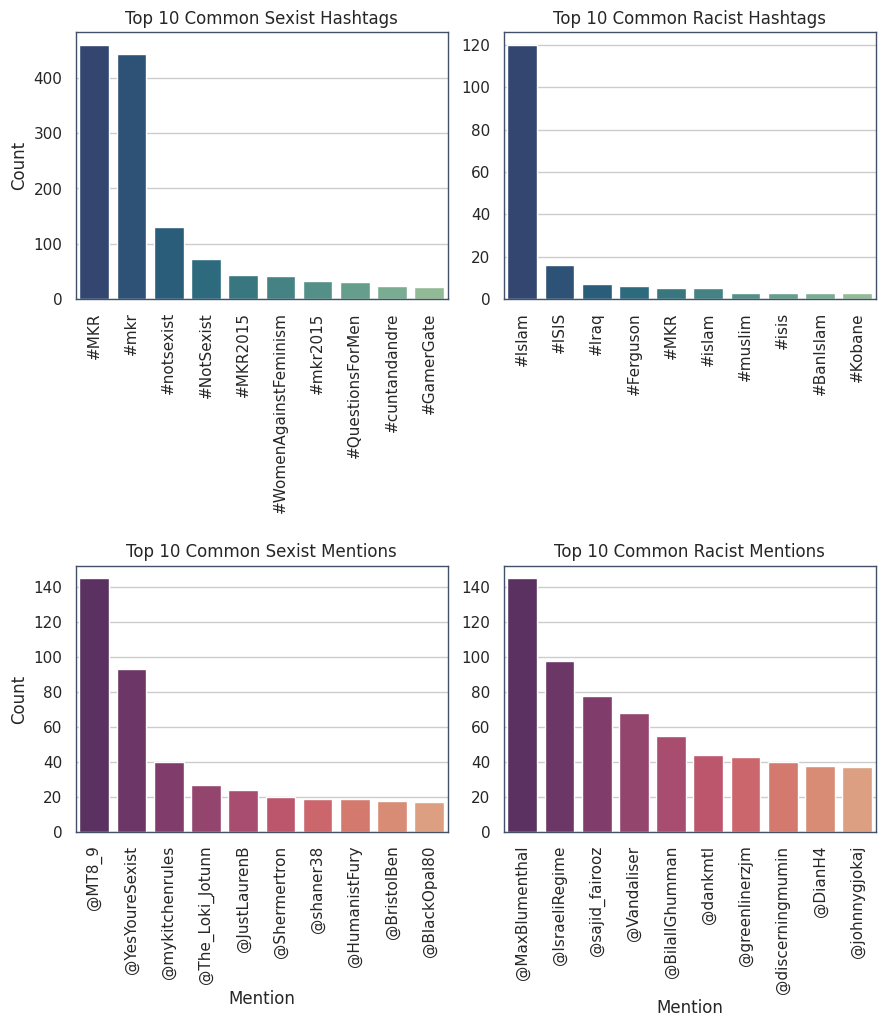

In [16]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
sns.barplot(x='Label', y='Count', data=top_10_sexist_hashtags, palette='crest_r')
plt.title('Top 10 Common Sexist Hashtags')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(222)
sns.barplot(x='Label', y='Count', data=top_10_racist_hashtags, palette='crest_r')
plt.title('Top 10 Common Racist Hashtags')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(223)
sns.barplot(x='Label', y='Count', data=top_10_sexist_mentions, palette='flare_r')
plt.title('Top 10 Common Sexist Mentions')
plt.xlabel('Mention')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(224)
sns.barplot(x='Label', y='Count', data=top_10_racist_mentions, palette='flare_r')
plt.title('Top 10 Common Racist Mentions')
plt.xlabel('Mention')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.15, hspace=1)
plt.show()

#### Key takeaways from the most common @ and #s

- For some reason `#MKR` and `#mkr` (my kitchen rules) feature on the top of the sexist hashtags. Maybe coz its a cooking show. lol. It might be due to the fact that #MKR is the most common hashtag on the dataset. <br>
- You can see religiously motived terrorist groups like `#isis` feature on the most common racist hashtags <br>
- `@YesYoureSexist` sounds like a provocative username. No wonder it has the second most sexist mentions 
- `@MaxBlumenthal` a controversial American author and blogger features on the top of Racist mentions

### Preprocessing the text 

In [17]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remove mentions and hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)
    
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    # Remove 'RT' (Retweet) indicator
    tweet = re.sub(r'\bRT\b', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     tweet_tokens = nltk.word_tokenize(tweet)
#     tweet = ' '.join([word for word in tweet_tokens if word not in stop_words])
    
    # Lemmatization
    doc = nlp(tweet)
    # Lemmatize each token and join them back into a string
    tweet = ' '.join([token.lemma_ for token in doc])
    
    return tweet

In [18]:
df['Text'] = df['Text'].apply(clean_tweet)
df.head()

,Text,Annotation,Label,num_hashtags,num_mentions,Sentiment_Label,Hashtags,Mentions
0,I read they in contextno change in mean th...,none,0.0,0,3,negative,[],"[@halalflaws, @biebervalue, @greenlinerzjm]"
1,now you idiot claim that people who try to s...,none,0.0,0,1,negative,[],[@ShreyaBafna3]
2,call I sexist but when I go to an auto plac...,sexism,1.0,0,1,positive,[],[@Mooseoftorment]
3,wrong isis follow the example of mohammed an...,racism,1.0,0,1,negative,[],[@g0ssipsquirrelx]
4,no no no no no no,none,0.0,1,0,negative,[#mkr],[]


In [19]:
print('_________Sample clean tweets_________')
simple_tweet = df[df['Label'] == 0]['Text'].iloc[1]
print('\n\nSimple tweet: ', simple_tweet)
sexist_tweet = df[df['Annotation'] == 'sexism']['Text'].iloc[0]
print('\n\nSexist tweet: ', sexist_tweet)
racist_tweet = df[df['Annotation'] == 'racism']['Text'].iloc[0]
print('\n\nRacist tweet: ', racist_tweet)
print('\n\n_______________________________')

_________Sample clean tweets_________


Simple tweet:    now you idiot claim that people who try to stop he from become a terrorist make he a terrorist islamically brain dead


Sexist tweet:     call I sexist but when I go to an auto place i d rather talk to a guy


Racist tweet:    wrong isis follow the example of mohammed and the quran exactly


_______________________________


### ☁️ Wordclouds for toxic text <a class="anchor"  id="section_1_3"></a>


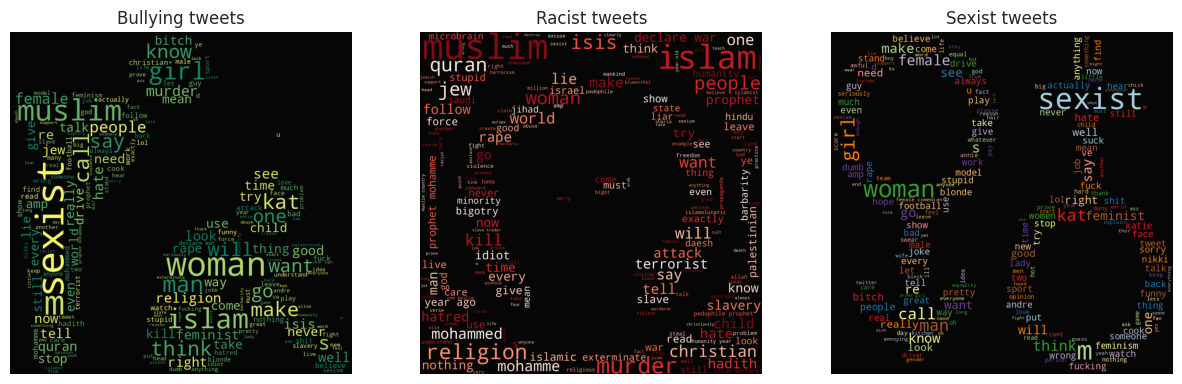

In [20]:
stopword=set(STOPWORDS)
plt.figure(figsize=(15,40))

## Common words in all bullying tweets-----------------------------------------------------------------------------------
plt.subplot(131)
# 1. Get text
bully_text = df[df.Label==1.0]["Text"].values
Text = ''
for text in bully_text:
    Text += text

# 2. Load png image from url and create mask
image_url = 'https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/bullying-computer-icons-harassment-clip-art-bully.jpg'
response = requests.get(image_url, stream=True)
response.raise_for_status()
mask = np.array(Image.open(response.raw))

# 3. Plot wordcloud
wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.axis("off")
plt.title('Bullying tweets')
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), alpha=0.98)


## Common words in all racist tweets-----------------------------------------------------------------------------------
# Repeat for other plots
plt.subplot(132)
bully_text = df[df.Annotation=='racism']["Text"].values
Text = ''
for text in bully_text:
    Text += text
    
image_url = 'https://clipart-library.com/img1/1475559.png'
response = requests.get(image_url, stream=True)
response.raise_for_status()
mask = np.array(Image.open(response.raw))

wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.title('Racist tweets')
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)


## Common words in all sexist tweets-----------------------------------------------------------------------------------
plt.subplot(133)
bully_text = df[df.Annotation=='sexism']["Text"].values
Text = ''
for text in bully_text:
    Text += text
    
image_url = 'https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/woman-gender-symbol-male-female-text-line-circle-number-png-clipart.jpg'
response.raise_for_status()
response = requests.get(image_url, stream=True)
mask = np.array(Image.open(response.raw))

wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.axis("off")
plt.title('Sexist tweets')
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

# 👾 CREATING Models 

In [21]:
# ignore this. I did this for ease of processing when i restart the kernel
# this part gives you the completely preprocessed data right to the point where you just need to oversample and split it

df = pd.read_csv("/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv")
df = df.drop(['id', 'index'], axis=1)
df.rename(columns={'oh_label': 'Label'}, inplace=True)
df = df.dropna(subset=['Label'])

# Adding hashtags and mentions_____________________________________________________________________________________# 
# here we create a function to count the number of hashtags and mentions and then create two columns to store this data
def count_symbols(text):
#     hashtag_count = len(re.findall(r'#', text))
    mention_count = len(re.findall(r'@', text))
#     return hashtag_count, mention_count
    return mention_count

# Apply the function to each row in the 'text' column
df[['num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))
# df[['num_hashtags', 'num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))


# Analyze sentiment of each text____________________________________________________________________________________# 
sia = SentimentIntensityAnalyzer()

# Function to get sentiment of a text
def get_sentiment(text):
    compound_score = sia.polarity_scores(text)['compound']
    return 'positive' if compound_score >= 0 else 'negative'

# Apply the function to each row in the 'Text' column
df['Sentiment_Label'] = df['Text'].apply(get_sentiment)


# Cleaning the tweets_________________________________________________________________________________________________# 
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remove mentions and hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)
    
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    # Remove 'RT' (Retweet) indicator
    tweet = re.sub(r'\bRT\b', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
      
    # Lemmatization
    doc = nlp(tweet)
    # Lemmatize each token and join them back into a string
    tweet = ' '.join([token.lemma_ for token in doc])
    
    return tweet

df['Text'] = df['Text'].apply(clean_tweet)
#____________________________________________________________________________________________________________________# 

# One hot encoding of the sentiment category
one_hot_encoded = pd.get_dummies(df['Sentiment_Label'], prefix='sentiment')
df = pd.concat([df, one_hot_encoded], axis=1)
df = df.drop('Sentiment_Label', axis=1)
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True).str.strip()
df['Text'] = df['Text'].str.strip()

# Step 2: Upsample the data using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)

# convert text (object) data to string for w2v
X_resampled= [str(obj) for obj in X_resampled]
X_resampled = np.array(X_resampled)

In [22]:
# Step 2: Oversample the data using RandomOverSampler to reduce imbalance between Labels (Bullying and non bullying)
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)

# convert text (object) data to string for w2v
X_resampled= [str(obj) for obj in X_resampled]
X_resampled = np.array(X_resampled)

## ML approach with word2vec <a class="anchor"  id="section_2_1"></a>
#### Why use Word2Vec?
- Semantic understanding: Word2Vec captures the semantic relationships between words, which is crucial for understanding the nuances of language used in bullying. It can differentiate between words with similar spellings but different meanings (e.g., "joke" vs. "mock") and identify synonyms and antonyms, helping to detect subtle insults and sarcasm often employed in cyberbullying.

- Handling slang and abbreviations: Twitter language is full of slang, abbreviations, and emojis. Word2Vec can learn these informal and often-evolving expressions, leading to more accurate detection of bullying even when it doesn't use traditional language patterns.


#### Limitations of using Word2Vec
- Bias: Word2Vec models can inherit biases from the training data, potentially leading to discriminatory outcomes. Careful selection of training data and evaluation methods are crucial.
- Context sensitivity: Subtle forms of bullying often rely on context not captured solely by word meaning. Combining Word2Vec with other approaches that consider context can improve accuracy.

For detailed explaination of the intuition behind W2V read: [Word2Vec Explained](https://archive.is/4lJS5)

In [23]:
# Train Word2Vec Model
sentences = [word_tokenize(text) for text in X_resampled]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # Adjust parameters as needed

# Convert Text to Embeddings
def get_embedding(text):
    tokens = word_tokenize(text)
    # Filter out tokens that are not in the vocabulary
    tokens = [token for token in tokens if token in word2vec_model.wv.key_to_index]
    if len(tokens) > 0:
        # Return the average of word embeddings for the tokens
        return np.mean([word2vec_model.wv[t] for t in tokens], axis=0)
    else:
        return None

# Create an array of embeddings for each text
X_resampled = [get_embedding(text) for text in X_resampled]

### 👻 Train test split 80:20

In [24]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 5: Model Training (Using a RandomForestClassifier as an example)
X_train = np.array(X_train)
X_test = np.array(X_test)

"""
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
"""

'\nmodel = RandomForestClassifier(random_state=42)\nmodel.fit(X_train, y_train)\n\n# Evaluate the model\ny_pred = model.predict(X_test)\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Accuracy: {accuracy}")\n\nf1 = f1_score(y_test, y_pred)\nprint(f"F1 Score: {f1}")\n'

In [35]:
from tqdm m import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, recall_score
import pandas as pd

def compare_models(x_train, y_train, x_test, y_test):
  """
  This function compares three classification models: Random Forest, SVM, and Naive Bayes.

  Args:
      x_train: Training data features.
      y_train: Training data labels.
      x_test: Testing data features.
      y_test: Testing data labels.

  Returns:
      A pandas DataFrame comparing the models on accuracy, F1-score, and recall.
  """

  # Define models
  models = {
      'Random Forest': RandomForestClassifier(),
      'SVM': SVC(),
      'Naive Bayes': GaussianNB()
  }

  # Define evaluation metrics function
  def evaluate_model(model_name, model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    return pd.Series({'Model': model_name, 'Accuracy': accuracy, 'F1-Score': f1, 'Recall': recall})

  # Evaluate models and store results in a DataFrame
  results = []
  for name, model in tqdm(models.items(), desc="Evaluating Models"):
    results.append(evaluate_model(name, model))

  return pd.DataFrame(results).set_index('Model')

# first Spli
results_df = compare_models(X_train, y_train, X_test, y_test)
results_df.head()

Evaluating Models: 100%|██████████| 3/3 [02:38<00:00, 52.87s/it]


,Accuracy,F1-Score,Recall
Model,,,
Random Forest,0.888068,0.888040,0.888068
SVM,0.709411,0.701343,0.709411
Naive Bayes,0.670724,0.664687,0.670724


### Train test split 70:30

In [36]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Step 5: Model Training (Using a RandomForestClassifier as an example)
X_train = np.array(X_train)
X_test = np.array(X_test)


In [37]:
# Example usage
results2_df = compare_models(X_train, y_train, X_test, y_test)
results2_df.head()

Evaluating Models: 100%|██████████| 3/3 [02:19<00:00, 46.42s/it]


,Accuracy,F1-Score,Recall
Model,,,
Random Forest,0.875380,0.875314,0.875380
SVM,0.703521,0.694403,0.703521
Naive Bayes,0.670917,0.664826,0.670917


## 🧠 Deep learning models <a class="anchor"  id="section_2_2"></a>

In [25]:
# using the cleaned version of the dataset
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled = X_resampled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [26]:
# using keras tokenizer to find the length vocab 
#import tensorflow_text
from keras.preprocessing import sequence, text
#token = tensorflow_text.Tokenizer(num_words=None)
token = text.Tokenizer(num_words=None)
max_len = 40

token.fit_on_texts(list(X_train) + list(X_test))
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [27]:
print('Preprocessed text', X_train[1])
print('\nTokenized text', xtrain_seq[1])
print('\nPadded text', xtrain_pad[1])
print('\nPadded text Length: ', len(xtrain_pad[1]))

Preprocessed text I m not sexist but girl should not wrestle

Tokenized text [3, 18, 4, 19, 14, 45, 71, 4, 2156]

Padded text [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    3   18    4   19   14   45   71    4 2156]

Padded text Length:  40


In [ ]:
"""
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

"""

In [ ]:
"""
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
"""

### **CNN with trainable embedding**

### 1 -- ration 80:20

In [28]:
y_train.shape

(18401,)

In [29]:
import keras
from keras.utils import to_categorical 
y_train_cat = keras.utils.to_categorical(y_train, num_classes=2) 

In [30]:
y_train_cat

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:

#-first/original
"""
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Embedding, Dense
from tensorflow.keras.models import Sequential

with strategy.scope():
  # Define the CNN model
  model = Sequential()

  # Embedding layer for word representation
  model.add(Embedding(len(word_index) + 1,
                      300,
                      input_length=max_len))

  # Convolutional layers to extract features
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  # Optional additional convolutional layers for more complex features
  # model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  # model.add(MaxPooling1D(pool_size=2))

  # Global Average Pooling to capture overall feature representation
  model.add(GlobalAveragePooling1D())

  # Dense layer for classification
  model.add(Dense(2, activation='softmax'))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()
"""

In [31]:
# with softmax 

from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Embedding, Dense
from tensorflow.keras.models import Sequential

with strategy.scope():
  # Define the CNN model
  model = Sequential()

  # Embedding layer for word representation
  model.add(Embedding(len(word_index) + 1,
                      300,
                      input_length=max_len))

  # Convolutional layers to extract features
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  # Optional additional convolutional layers for more complex features
  # model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  # model.add(MaxPooling1D(pool_size=2))

  # Global Average Pooling to capture overall feature representation
  model.add(GlobalAveragePooling1D())

  # Dense layer for multi-class classification
  model.add(Dense(2, activation='softmax'))  # Update with number of classes

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           3801300   
                                                                 
 conv1d (Conv1D)             (None, 38, 128)           115328    
                                                                 
 max_pooling1d (MaxPooling1  (None, 19, 128)           0         
 D)                                                              
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 3916886 (14.94 MB)
Trainable params: 39168

In [32]:
model.fit(xtrain_pad, y_train_cat, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
288/288 [==============================] - 23s 68ms/step - loss: 0.4922 - accuracy: 0.7610
Epoch 2/5
288/288 [==============================] - 6s 21ms/step - loss: 0.3058 - accuracy: 0.8774
Epoch 3/5
288/288 [==============================] - 3s 10ms/step - loss: 0.2164 - accuracy: 0.9175
Epoch 4/5
288/288 [==============================] - 2s 7ms/step - loss: 0.1567 - accuracy: 0.9420
Epoch 5/5
288/288 [==============================] - 3s 9ms/step - loss: 0.1171 - accuracy: 0.9586


In [33]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
import pandas as pd

def evaluate_CNNmodel(X_train, X_test, y_train, y_test, model=None):
  """
  Fits a model, predicts on test data, and returns evaluation metrics.

  Args:
      X_train: Training data features.
      X_test: Testing data features.
      y_train: Training data labels.
      y_test: Testing data labels.
      model: The machine learning model to fit and evaluate.

  Returns:
      A pandas DataFrame containing evaluation metrics (accuracy, F1-score, recall).
  """

  # Fit the model
  #model.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)

  # Create a DataFrame with the results
  results_df = pd.DataFrame({
      "Metric": ["Accuracy", "F1-Score", "Recall"],
      "Value": [accuracy, f1, recall]
  })

  return results_df, 


In [34]:
model_results = evaluate_CNNmodel(X_train, xvalid_pad, y_train, y_test, model)
print(model_results)


144/144 [==============================] - 0s 2ms/step
(     Metric     Value
0  Accuracy  0.868507
1  F1-Score  0.866475
2    Recall  0.872832,)


### 2 -- Ration 70:30

In [35]:
# using the cleaned version of the dataset
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled = X_resampled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [36]:

# using keras tokenizer to find the length vocab 
#import tensorflow_text
from keras.preprocessing import sequence, text
#token = tensorflow_text.Tokenizer(num_words=None)
token = text.Tokenizer(num_words=None)
max_len = 40

token.fit_on_texts(list(X_train) + list(X_test))
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index


In [37]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes=2) 


In [38]:
# with softmax 

from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Embedding, Dense
from tensorflow.keras.models import Sequential

with strategy.scope():
  # Define the CNN model
  model = Sequential()

  # Embedding layer for word representation
  model.add(Embedding(len(word_index) + 1,
                      300,
                      input_length=max_len))

  # Convolutional layers to extract features
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  # Optional additional convolutional layers for more complex features
  # model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  # model.add(MaxPooling1D(pool_size=2))

  # Global Average Pooling to capture overall feature representation
  model.add(GlobalAveragePooling1D())

  # Dense layer for multi-class classification
  model.add(Dense(2, activation='softmax'))  # Update with number of classes

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 300)           3801300   
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 128)           115328    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 19, 128)           0         
 g1D)                                                            
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 3916886 (14.94 MB)
Trainable params: 391

In [40]:
model.fit(xtrain_pad, y_train_cat, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
252/252 [==============================] - 2s 8ms/step - loss: 0.0953 - accuracy: 0.9657
Epoch 2/5
252/252 [==============================] - 1s 5ms/step - loss: 0.0794 - accuracy: 0.9719
Epoch 3/5
252/252 [==============================] - 2s 7ms/step - loss: 0.0682 - accuracy: 0.9765
Epoch 4/5
252/252 [==============================] - 2s 7ms/step - loss: 0.0574 - accuracy: 0.9802
Epoch 5/5
252/252 [==============================] - 1s 4ms/step - loss: 0.0501 - accuracy: 0.9829


In [41]:
model_results = evaluate_CNNmodel(X_train, xvalid_pad, y_train, y_test, model)
print(model_results)


216/216 [==============================] - 0s 2ms/step
(     Metric     Value
0  Accuracy  0.854514
1  F1-Score  0.857021
2    Recall  0.883182,)


# ⬅️➡️ DISTILLBERT with Tensorflow Hub <a class="anchor"  id="section_2_3"></a>

In [45]:
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled = X_resampled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [46]:
import keras
from keras.utils import to_categorical 
y_train_cat = keras.utils.to_categorical(y_train, num_classes=2)

In [47]:
# creating tensorflow datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))

test_dataset = tf.data.Dataset.from_tensor_slices((X_test))

BUFFER_SIZE = 4000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [48]:
print("Train dataset element spec:", train_dataset.element_spec)
print("Test dataset element spec:", test_dataset.element_spec)

Train dataset element spec: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))
Test dataset element spec: TensorSpec(shape=(None,), dtype=tf.string, name=None)


In [49]:
for example, label in train_dataset.take(1): # take returns a batch of train_dataset, containing 64 feature, label pairs.
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'lol raw egg'
 b'dangerous to outsource iraq security to shia militia know for disappearance amp execution'
 b'for the dessert be you kid I wtf be go on']

labels:  [[1. 0.]
 [0. 1.]
 [1. 0.]]


In [50]:
# loading the preprocessing and main model from tf hub links

#tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2'
#tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

tfhub_handle_encoder = 'https://www.kaggle.com/models/jeongukjae/distilbert/TensorFlow2/en-cased-l-6-h-768-a-12/1'
tfhub_handle_preprocess = 'https://kaggle.com/models/jeongukjae/distilbert/TensorFlow2/en-cased-preprocess/2'

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

Here we take some sample input texts and test the bert preprocess model on them. We analyze the outputs given by the model below

In [51]:
# Testing the bert preprocessor

text_test = ["Today's weather is harsh", "My name is harsh"]
text_preprocessed = bert_preprocess_model(text_test)

for i in range(len(text_test)):
    print('Input text :', text_test[i])
    print(f'Keys       : {list(text_preprocessed.keys())}')
    print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
    print(f'Word Ids   : {text_preprocessed["input_word_ids"][i, :12]}')
    print(f'Input Mask : {text_preprocessed["input_mask"][i, :12]}')
    #print(f'Type Ids   : {text_preprocessed["input_type_ids"][i, :12]}')
    print('\n')
# input_type_ids has the same shape as input_mask, but inside the non-padded region,
# contains a 0 or a 1 indicating which sentence the token is a part of.

# context is not being mapped at the preprocessing layer
# The word 'Harsh' will have the same token no matter what the scenario
# BERT will perform the contextualization when the text is passed through it

Input text : Today's weather is harsh
Keys       : ['input_word_ids', 'input_mask']
Shape      : (2, 128)
Word Ids   : [ 101 3570  112  188 4250 1110 8213  102    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]


Input text : My name is harsh
Keys       : ['input_word_ids', 'input_mask']
Shape      : (2, 128)
Word Ids   : [ 101 1422 1271 1110 8213  102    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 0 0 0 0 0 0]




In [52]:
# Model link: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Keys       : {list(bert_results.keys())}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Encoder Outputs Shape:{bert_results["encoder_outputs"][0].shape}')
# print(f'Encoder Outputs Values:{bert_results["encoder_outputs"][0][0, :3]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :3]}')

# BERT takes our sentence and outputs a 768 token pooled representation, where every word is mapped in a 128 dimension array

Loaded BERT: https://www.kaggle.com/models/jeongukjae/distilbert/TensorFlow2/en-cased-l-6-h-768-a-12/1
Keys       : ['pooled_output', 'sequence_output', 'encoder_outputs']
Pooled Outputs Shape:(2, 768)
Pooled Outputs Values:[ 0.28232425 -0.10343738  0.06757673 -0.24518059 -0.2648146   0.1790519
  0.19207096 -0.00241254 -0.03184228 -0.9497169  -0.2668226   0.21750292]
Encoder Outputs Shape:(2, 128, 768)
Sequence Outputs Shape:(2, 128, 768)


- The pooled outputs provide a fixed-size representation of the entire input sequence,
- The encoder outputs represent the contextualized embeddings of each token, and the sequence
- Outputs retain token-level information for more detailed analysis or tasks.
- Either of those can be used as input to further model building depending on granularity of the task

In [ ]:
# first/original

# A function that takes in the links for the model and returns a newly compiled model

def create_model(model_link, preprocess_link):
  # bert_model = hub.KerasLayer(model_link)
  # bert_preprocess_model = hub.KerasLayer(preprcess_link)

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(preprocess_link, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(model_link, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

    model = tf.keras.Model(text_input, net)

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                              loss=loss,
                              metrics=metrics)
    return model

In [53]:
# A function that takes in the links for the model and returns a newly compiled model

def create_model(model_link, preprocess_link):
  # bert_model = hub.KerasLayer(model_link)
  # bert_preprocess_model = hub.KerasLayer(preprcess_link)

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(preprocess_link, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(model_link, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)

    model = tf.keras.Model(text_input, net)

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                              loss=loss,
                              metrics=metrics)
    return model

In [54]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
import pandas as pd

def evaluate_DBmodel(X_test, y_test, model=None):
  """
  Fits a model, predicts on test data, and returns evaluation metrics.

  Args:
      X_train: Training data features.
      X_test: Testing data features.
      y_train: Training data labels.
      y_test: Testing data labels.
      model: The machine learning model to fit and evaluate.

  Returns:
      A pandas DataFrame containing evaluation metrics (accuracy, F1-score, recall).
  """

  # Fit the model
  #model.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = tf.sigmoid(model(tf.constant(X_test)))
  #y_pred = tf.nn.softmax(model(tf.constant(X_test)))
  y_pred = np.argmax(y_pred, axis=1)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)

  # Create a DataFrame with the results
  results_df = pd.DataFrame({
      "Metric": ["Accuracy", "F1-Score", "Recall"],
      "Value": [accuracy, f1, recall]
  })

  return results_df, 


### Training DistilBert on ratio 80:20

In [55]:
DATA_SIZE = tf.data.experimental.cardinality(train_dataset).numpy()

print("Size of the dataset:", DATA_SIZE)
BATCH_SIZE = 16
STEPS_PER_EPOCH = DATA_SIZE // BATCH_SIZE

Size of the dataset: 288


In [ ]:
# bert_en_uncased_L-4_H-256_A-4/2

with strategy.scope():
    model = create_model(tfhub_handle_encoder, tfhub_handle_preprocess)
model.fit(train_dataset, epochs=5, batch_size=16)
# directly passed in the train_dataset tensor to the model as the preprocessing layer takes care of embedding

Epoch 1/5
288/288 [==============================] - 193s 595ms/step - loss: 0.4467 - binary_accuracy: 0.8000
Epoch 2/5
288/288 [==============================] - 172s 596ms/step - loss: 0.2764 - binary_accuracy: 0.8913
Epoch 3/5
288/288 [==============================] - 172s 597ms/step - loss: 0.1647 - binary_accuracy: 0.9424
Epoch 4/5
115/288 [==========>...................] - ETA: 1:43 - loss: 0.1005 - binary_accuracy: 0.9639

In [ ]:
# since the model is showing continued improvements let us train it some more
#model.fit(train_dataset, epochs=5, batch_size=16)

In [ ]:
model_results = evaluate_DBmodel(X_test[:2000], y_test[:2000], model)
print(model_results)

(     Metric     Value
0  Accuracy  0.902000
1  F1-Score  0.902488
2    Recall  0.919878,)


In [ ]:
#y_pred = tf.sigmoid(model(tf.constant(X_test)))

### Train DistilBert on ratio 70:30

In [68]:
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled = X_resampled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

y_train_cat = keras.utils.to_categorical(y_train, num_classes=2)


In [69]:
# creating tensorflow datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))

test_dataset = tf.data.Dataset.from_tensor_slices((X_test))

BUFFER_SIZE = 4000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [70]:
DATA_SIZE = tf.data.experimental.cardinality(train_dataset).numpy()

print("Size of the dataset:", DATA_SIZE)
BATCH_SIZE = 16
STEPS_PER_EPOCH = DATA_SIZE // BATCH_SIZE



# bert_en_uncased_L-4_H-256_A-4/2

with strategy.scope():
    model = create_model(tfhub_handle_encoder, tfhub_handle_preprocess)
model.fit(train_dataset, epochs=5, batch_size=16)
# directly passed in the train_dataset tensor to the model as the preprocessing layer takes care of embedding



Size of the dataset: 252
Epoch 1/5
252/252 [==============================] - 174s 602ms/step - loss: 0.4649 - binary_accuracy: 0.7931
Epoch 2/5
252/252 [==============================] - 151s 598ms/step - loss: 0.2963 - binary_accuracy: 0.8834
Epoch 3/5
252/252 [==============================] - 151s 599ms/step - loss: 0.1787 - binary_accuracy: 0.9348
Epoch 4/5
252/252 [==============================] - 151s 599ms/step - loss: 0.1104 - binary_accuracy: 0.9607
Epoch 5/5
252/252 [==============================] - 151s 598ms/step - loss: 0.0756 - binary_accuracy: 0.9751


In [ ]:
"""
model_results = evaluate_DBmodel(test_dataset, y_test, model)
print(model_results)
"""

In [71]:
y_pred = tf.sigmoid(model(tf.constant(X_test[:1000])))
y_pred = np.argmax(y_pred, axis=1)
# Calculate evaluation metrics
accuracy = accuracy_score(y_test[:1000], y_pred)
f1 = f1_score(y_test[:1000], y_pred)
recall = recall_score(y_test[:1000], y_pred)
print(recall)

# Create a DataFrame with the results
results_df = pd.DataFrame({
      "Metric": ["Accuracy", "F1-Score", "Recall"],
      "Value": [accuracy, f1, recall]
  })
results_df

0.8807157057654076


,Metric,Value
0,Accuracy,0.875000
1,F1-Score,0.876360
2,Recall,0.880716
